# Assignment1 : Sentiment analysis

## The process
- Data loading and preparation
- Pre-Processing
    - Text Cleaning
    - Tokenising
    - stopwords removal
    - Part of speech tagging
    - stemming and lemmatizing
- Feature engineering
- Modeling and model selection
- Model tunning
- Performance Evaluting

## Library used

In [407]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#For removing
import re

#nltk
import nltk
from nltk import word_tokenize, pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn

#Vectorization (Bag of words)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#Cross validation
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut
from sklearn.model_selection import cross_val_score

#Data Modelling 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Model performance matrics
from sklearn.metrics import confusion_matrix,precision_score,f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1 – Data Loading and data preparation

## 1.1 Data loding and exploring

 x_train shape: (2400, 2)
 x_test shape: (600, 2)
 y_train shape: (2400, 1)
 y_test shape: (600, 1), 

 null value: y    0
dtype: int64
amount of training label, y
1    1200
0    1200
dtype: int64, 



Text(0.5, 0, 'Target')

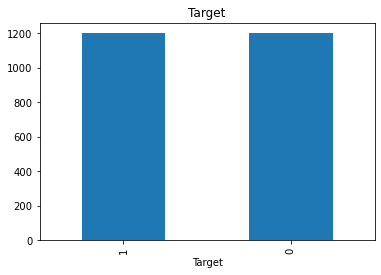

In [532]:
#Read data set
x_train = pd.read_csv("Dataset/x_train.csv", header =None, names=['domains', 'reviews'])
x_test = pd.read_csv("Dataset/x_test.csv", header =None, names=['domains', 'reviews'])
y_train = pd.read_csv("Dataset/y_train.csv", header =None, names=['y'])
y_test = pd.read_csv("Dataset/y_test.csv", header =None, names=['y'])

#See the shape po
print(f" x_train shape: {x_train.shape}")
print(f" x_test shape: {x_test.shape}")
print(f" y_train shape: {y_train.shape}")
print(f" y_test shape: {y_test.shape}, \n")


#Check if there is any null value
print(f' null value: {y_train.isnull().sum()}')



#check to balance of the label
print(f'amount of training label, {y_train.value_counts()}, \n')

ax = y_train['y'].value_counts().plot(kind = 'bar',
    title = 'Target')
ax.set_xlabel("Target")

## 1.2 Preprocessing

In [533]:
# Pre-processing

## 1. Cleanning data

#Define a function to clean the text
def clean(text):
    #Remove all special characters and numericals, puntuation, leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    #lower case conversion
    text = text.lower()
    return text


## Tokenize words
def token(text):
    token = nltk.word_tokenize(text)
    return token

##  Remove Stopwords
def stopword(text):
    new_text = (" ").join(ele for ele in text if ele.lower() not in set(stopwords.words('english')))
    return new_text

## POS tagging
def POS(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, tag]))
    return newlist

#2. lemmatizing
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN
    
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
    #lemmaw = ps.stem(word)
        lemma = wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


# Apply Clean() to data (removing all lowwercase and punctuation)
x_train['cleanned'] = x_train['reviews'].apply(clean)
x_test['cleanned'] = x_test['reviews'].apply(clean)

# Apply token() to data
x_train['tokenned'] = x_train['cleanned'].apply(token)
x_test['tokenned'] = x_test['cleanned'].apply(token)

# Apply stopword to data (Remove stopwords)
x_train['stopwordRemoved'] = x_train['tokenned'].apply(stopword)
x_test['stopwordRemoved'] = x_test['tokenned'].apply(stopword)

# Apply POS to data (Part -of speech)
x_train['tag'] = x_train['stopwordRemoved'].apply(POS)
x_test['tag'] = x_test['stopwordRemoved'].apply(POS)

# Lemmatizer
x_train['lemma'] = x_train['tag'].apply(lemmatize)
x_test['lemma'] = x_test['tag'].apply(lemmatize)

In [540]:
x_train.head()

,domains,reviews,cleanned,tokenned,stopwordRemoved,tag,lemma
0,amazon,Oh and I forgot to also mention the weird colo...,oh and i forgot to also mention the weird colo...,"[oh, and, i, forgot, to, also, mention, the, w...",oh forgot also mention weird color effect phone,"[(oh, UH), (forgot, NN), (also, RB), (mention,...",oh forgot also mention weird color effect phone
1,amazon,THAT one didn't work either.,that one didn t work either,"[that, one, didn, t, work, either]",one work either,"[(one, CD), (work, NN), (either, CC)]",one work either
2,amazon,Waste of 13 bucks.,waste of bucks,"[waste, of, bucks]",waste bucks,"[(waste, NN), (bucks, NNS)]",waste buck
3,amazon,"Product is useless, since it does not have eno...",product is useless since it does not have enou...,"[product, is, useless, since, it, does, not, h...",product useless since enough charging current ...,"[(product, NN), (useless, JJ), (since, IN), (e...",product useless since enough charge current ...
4,amazon,None of the three sizes they sent with the hea...,none of the three sizes they sent with the hea...,"[none, of, the, three, sizes, they, sent, with...",none three sizes sent headset would stay ears,"[(none, NN), (three, CD), (sizes, VBZ), (sent,...",none three size send headset would stay ear


## Task2: Feature representation

In [542]:
# Vectorization (feature extraction)

##TF-IDF
#ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
#min_df = 2 Excluding rare words less than 2 times
vectorizer = TfidfVectorizer(sublinear_tf= True, min_df=2, norm='l2', ngram_range=(1, 2), stop_words='english')
X_train_vc_tf = vectorizer.fit_transform(x_train['lemma'])
X_train_ready = pd.DataFrame(X_train_vc_tf.toarray(), columns=vectorizer.get_feature_names())


## Bag of word
# vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
# X_train_vc = vectorizer2.fit_transform(x_train['lemma'])
# X_train_ready2 = pd.DataFrame(X_train_vc.toarray(), columns= vectorizer2.get_feature_names())

X_test_vc_tf = vectorizer.transform(x_test['lemma'])
X_test_ready = pd.DataFrame(X_test_vc_tf.toarray(), columns=vectorizer.get_feature_names())


In [543]:
X_train_ready.head()

,ability,able,absolutely,absolutely amaze,absolutely love,access,accuse,accuse murder,act,act bad,...,wrong,yeah,year,year ago,year old,yes,young,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [545]:
X_test_ready.head()

,ability,able,absolutely,absolutely amaze,absolutely love,access,accuse,accuse murder,act,act bad,...,wrong,yeah,year,year ago,year old,yes,young,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [579]:
print(f' X_train shape after feature engineering: {X_train_ready.shape}')
print(f' X_train shape after feature engineering: {X_test_ready.shape}')

 X_train shape after feature engineering: (2400, 1956)
 X_train shape after feature engineering: (600, 1956)


# Task 3 – Classification and Evaluation

In [546]:
X_train = X_train_ready
X_test = X_test_ready
y_train = y_train
y_true = y_test

print(X_train.shape)
print(X_test.shape)

(2400, 1956)
(600, 1956)


## 3.1 Model trainning (Spliting training set and validation set)
We will train in three diffrent folds (3, 5, 10)

### Model 1: Logistic Regression

In [548]:
nSplit = [3 ,5 ,10]
resultLR = []


for suite_split in nSplit:
    LogReg = LogisticRegression(random_state = 24)
    cv = StratifiedKFold(n_splits = suite_split, random_state =24, shuffle = True)
    scores = cross_val_score(LogReg, X_train, np.ravel(y_train), cv=cv, scoring = 'accuracy')

    resultLR.append({
        "Model" : "Logistic Regression",
        "n_split" : suite_split,
        #"CrosvalidationScore" : scores,
        "Mean CrosValidataionScore": np.mean(scores)
    }
    )
resultLR

[{'Model': 'Logistic Regression',
  'n_split': 3,
  'Mean CrosValidataionScore': 0.7858333333333333},
 {'Model': 'Logistic Regression',
  'n_split': 5,
  'Mean CrosValidataionScore': 0.7933333333333333},
 {'Model': 'Logistic Regression',
  'n_split': 10,
  'Mean CrosValidataionScore': 0.7958333333333333}]

### Model2: SVM 

In [549]:

def evaluate(y_true,y_pred):
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    rec = metrics.precision_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    conf = confusion_matrix(y_true, y_pred)
    return {'Classification accuracy': acc,
           'precision' : prec,
           'recall' : rec,
           'F1 score' : f1
           #'confusion_matrics' : conf
           }


nSplit = [3 ,5 ,10]
resultSVM = []


for suite_split in nSplit:
    clf = SVC(kernel='linear')
    cv = StratifiedKFold(n_splits = suite_split,  random_state =24, shuffle = True)
    scores = cross_val_score(clf, X_train, np.ravel(y_train), cv=cv, scoring = 'accuracy')

    resultSVM.append({
        "Model" : "SVM",
        "n_split" : suite_split,
        #"CrosvalidationScore" : scores,
        "Mean CrosValidataionScore": np.mean(scores)
    }
    )
resultSVM

[{'Model': 'SVM',
  'n_split': 3,
  'Mean CrosValidataionScore': 0.7783333333333333},
 {'Model': 'SVM',
  'n_split': 5,
  'Mean CrosValidataionScore': 0.7883333333333333},
 {'Model': 'SVM', 'n_split': 10, 'Mean CrosValidataionScore': 0.795}]

### Model3 : Naive Bayes

In [550]:
nSplit = [3 ,5 ,10]
resultNB = []


for suite_split in nSplit:
    model = GaussianNB()
#     cv = StratifiedKFold(n_splits = suite_split)
    scores = cross_val_score(model, X_train, np.ravel(y_train), cv=cv, scoring = 'accuracy')
    
    resultNB.append({
        "Model" : "Naive_Bayes",
        "n_split" : suite_split,
        #"CrosvalidationScore" : scores,
        "Mean CrosValidataionScore": np.mean(scores)
    }
    )
resultNB

[{'Model': 'Naive_Bayes',
  'n_split': 3,
  'Mean CrosValidataionScore': 0.7179166666666666},
 {'Model': 'Naive_Bayes',
  'n_split': 5,
  'Mean CrosValidataionScore': 0.7179166666666666},
 {'Model': 'Naive_Bayes',
  'n_split': 10,
  'Mean CrosValidataionScore': 0.7179166666666666}]

In [551]:
resultLR = pd.DataFrame(resultLR)
resultSVM = pd.DataFrame(resultSVM)
resultNB = pd.DataFrame(resultNB)

compare = pd.concat([resultLR, resultSVM], ignore_index = True)
compareAll = pd.concat([compare, resultNB], ignore_index = True)

In [552]:
compareAll

,Model,n_split,Mean CrosValidataionScore
0,Logistic Regression,3,0.785833
1,Logistic Regression,5,0.793333
2,Logistic Regression,10,0.795833
3,SVM,3,0.778333
4,SVM,5,0.788333
5,SVM,10,0.795000
6,Naive_Bayes,3,0.717917
7,Naive_Bayes,5,0.717917
8,Naive_Bayes,10,0.717917


## 3.2 Performing the following steps for the chosen classifier on your data suites

In [553]:
# Logistic Regression

# Define parameter grid
param_grid = {'C': np.logspace(-4, 4, 9),
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
              'max_iter': [100, 500, 1000]}

# Instantiate logistic regression model
lr = LogisticRegression()

# Instantiate grid search cross-validation
grid_search = GridSearchCV(lr, param_grid, cv=10)

# Fit the grid search cross-validation object to the data
grid_search.fit(X_train, np.ravel(y_train))

# Print the best hyperparameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

Best parameters:  {'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score:  0.7970833333333334


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [554]:
#Train and predict the tunned model
lr = LogisticRegression(C = 1.0, max_iter = 100, penalty = "l2" , solver = 'liblinear')
lr_trained = lr.fit(X_train, y_train)
y_pred = lr_trained.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Performing Evaluation with the test set

[[244  56]
 [ 88 212]]


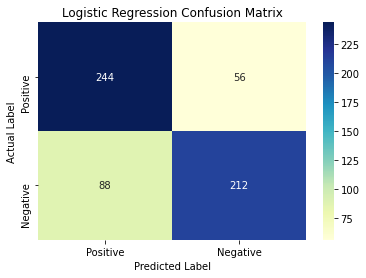

{'Classification accuracy': 0.76, 'precision': 0.7910447761194029, 'recall': 0.7910447761194029, 'F1 score': 0.7464788732394366}
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       300
           1       0.79      0.71      0.75       300

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600



In [555]:
#Confusion matrix

conf = confusion_matrix(y_test, y_pred)
print(conf)

#visualize confusion matrix
Class_label = ["Positive", "Negative"]
Class_label2 = ["Positive", "Negative"]
conf = pd.DataFrame(conf, index = Class_label, columns = Class_label2)
sns.heatmap(conf, annot = True, cmap = "YlGnBu", fmt = 'd')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


#Function for evaluating modle (acc, precision, recall, f1score, confusion metrix)
Evaluation = []

def evaluate(y_true,y_pred):
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    rec = metrics.precision_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    conf = confusion_matrix(y_true, y_pred)
    return {'Classification accuracy': acc,
           'precision' : prec,
           'recall' : rec,
           'F1 score' : f1
           #'confusion_matrics' : conf
           }

print(evaluate(y_test, y_pred))

print(classification_report(y_test, y_pred))

# Prediction Analysis

In [568]:
y_pred_res = pd.DataFrame(y_pred, columns= ['y_pred'])
y_true = pd.read_csv("Dataset/y_test.csv", header =None, names=['y_true'])
x_test_review = pd.read_csv("Dataset/x_test.csv", header= None, names = ['domains', 'reviews'])


# #Concatnate results with X_test
concat1 = pd.concat([y_true, y_pred_res], axis=1)
concatRes = pd.concat([x_test_review, concat1 ], axis=1)
concatRes

In [571]:
#To check False positive (negative y_true with positive predicted)
False_positive = concatRes[(concatRes['y_true']==0) & (concatRes['y_pred']== 1)]
False_positive 

,domains,reviews,y_true,y_pred
0,amazon,It only recognizes the Phone as its storage de...,0,1
1,amazon,Disappointing accessory from a good manufacturer.,0,1
8,amazon,I purchased this and within 2 days it was no l...,0,1
9,amazon,The picture resolution is far below what other...,0,1
11,amazon,My experience was terrible..... This was my fo...,0,1
21,amazon,Not as good as I had hoped.,0,1
23,amazon,Doesn't do the job.,0,1
30,amazon,Essentially you can forget Microsoft's tech su...,0,1
37,amazon,Does not fit.,0,1
38,amazon,Not good when wearing a hat or sunglasses.,0,1


In [572]:
#To check positive y_true with negative predicted
False_negative = concatRes[(concatRes['y_true']==1) & (concatRes['y_pred']== 0)]
False_negative 

,domains,reviews,y_true,y_pred
104,amazon,Cheap but hey it works.. Was pleasantly supris...,1,0
111,amazon,The delivery was on time.,1,0
113,amazon,The eargels channel the sound directly into yo...,1,0
114,amazon,(It works!),1,0
118,amazon,If you are Razr owner...you must have this!,1,0
...,...,...,...,...
583,yelp,You can't beat that.,1,0
589,yelp,These are the nicest restaurant owners I've ev...,1,0
590,yelp,First time going but I think I will quickly be...,1,0
591,yelp,My boyfriend and i sat at the bar and had a co...,1,0


In [573]:
#Testing
Y = vectorizer.transform(['I love this product'])
prediction = lr_trained.predict(Y)
print(prediction)

[1]


In [574]:
Y2 = vectorizer.transform(['This move sucks'])
prediction2 = lr_trained.predict(Y2)
print(prediction2)

[0]


In [575]:
Y3 = vectorizer.transform(['This move is highly recommended'])
prediction3 = lr_trained.predict(Y3)
print(prediction3)

[1]


In [576]:
Y4 = vectorizer.transform(['This movie is good but a bit slow'])
prediction4 = lr_trained.predict(Y4)
print(prediction4)

[0]


In [577]:
Y5 = vectorizer.transform(['This movie is not good but the actor played well'])
prediction5 = lr_trained.predict(Y5)
print(prediction5)

[1]


In [578]:
Y6 = vectorizer.transform(["""QV Skin Lotion repairs and soothes dry skin. 
With a luxuriously light formulation, it's easy to apply.For best results, 
apply after your bath or shower. Helps seal in natural moisture by acting as a protective barrier. 
Suitable for use on dry, scaly skin, winter itch, ichthyosis, xerosis, and dermatitis. 
Suitable for relief of symptoms of atopic eczema and psoriasis. Suitable for even sensitive skin types. 
Particularly suitable for infants and the elderly. I use it daily and totally loving it. 
Using for my kids as well"""])

prediction6 = lr_trained.predict(Y6)
print(prediction6)

[1]
